Overview
This project involves developing machine learning models for anomaly detection using Indian cyber threat data. The process includes data preparation, feature engineering, model training, evaluation, and deployment.

Dataset Analysis
The provided dataset Cyber-Threat-Intelligence-Custom-Data_new_processed.csv contains cyber threat intelligence records with multiple features including text descriptions, relations, diagnoses, solutions, and various entity identifiers

Step 1: Data Preparation
Loading and Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Load the dataset
df = pd.read_csv('/content/Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,476.0,4672.651261,4178.163473,105.0,2023.50,3442.5,4821.00,14408.0
id_1,476.0,41037.617647,16171.093234,377.0,45168.25,48220.5,50081.00,51779.0
start_offset_1,476.0,63.703782,62.684830,0.0,16.00,46.0,93.25,428.0
end_offset_1,476.0,77.376050,64.789955,4.0,28.00,58.5,110.00,451.0
id_2,476.0,43544.147059,13357.982594,771.0,45615.50,48311.0,50062.25,51777.0
start_offset_2,476.0,81.987395,68.756656,0.0,34.00,65.0,117.00,471.0
end_offset_2,476.0,98.976891,71.263909,4.0,49.00,88.5,134.00,535.0
id_3,329.0,45473.595745,10795.967067,976.0,46155.00,48862.0,50150.00,51781.0
start_offset_3,329.0,106.367781,88.730761,0.0,46.00,90.0,142.00,601.0
end_offset_3,329.0,122.650456,90.991503,5.0,66.00,108.0,160.00,665.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              476 non-null    int64  
 1   text            476 non-null    object 
 2   relations       476 non-null    object 
 3   diagnosis       475 non-null    object 
 4   solutions       476 non-null    object 
 5   id_1            476 non-null    int64  
 6   label_1         476 non-null    object 
 7   start_offset_1  476 non-null    int64  
 8   end_offset_1    476 non-null    int64  
 9   id_2            476 non-null    int64  
 10  label_2         476 non-null    object 
 11  start_offset_2  476 non-null    int64  
 12  end_offset_2    476 non-null    int64  
 13  id_3            329 non-null    float64
 14  label_3         329 non-null    object 
 15  start_offset_3  329 non-null    float64
 16  end_offset_3    329 non-null    float64
dtypes: float64(3), int64(7), object(7)


In [ ]:
df.head().T

,0,1,2,3,4
id,249,14309,13996,13600,14364
text,A cybersquatting domain save-russia[.]today is...,"Like the Android Maikspy, it first sends a not...",While analyzing the technical details of this ...,(Note that Flash has been declared end-of-life...,Figure 21. Connection of Maikspy variants to 1...
relations,"[{'from_id': 44658, 'id': 9, 'to_id': 44659, '...","[{'from_id': 48531, 'id': 445, 'to_id': 48532,...","[{'from_id': 48781, 'id': 461, 'to_id': 48782,...","[{'from_id': 51688, 'id': 1133, 'to_id': 51689...","[{'from_id': 51780, 'id': 1161, 'to_id': 44372..."
diagnosis,The diagnosis is a cyber attack that involves ...,The diagnosis is that the entity identified as...,Diagnosis: APT37/Reaper/Group 123 is responsib...,The diagnosis is a malware infection. The enti...,The diagnosis is that Maikspy malware variants...
solutions,1. Implementing DNS filtering to block access ...,1. Implementing a robust anti-malware software...,1. Implementing advanced threat detection tech...,1. Implementing a robust antivirus software th...,1. Implementing a robust firewall system that ...
id_1,44656,48530,48781,51687,51779
label_1,attack-pattern,SOFTWARE,threat-actor,TIME,URL
start_offset_1,2,9,188,62,163
end_offset_1,16,17,194,79,191
id_2,44657,48531,48782,51688,51777


Handling Missing Values

In [ ]:
# Check for null values
print(df.isnull().sum())

# Handling missing values
# For text columns, fill with empty string
text_columns = ['text', 'diagnosis', 'solutions']
for col in text_columns:
    df[col].fillna('', inplace=True)

# For numerical columns, fill with median or mode
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns.difference(text_columns)
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

id                  0
text                0
relations           0
diagnosis           1
solutions           0
id_1                0
label_1             0
start_offset_1      0
end_offset_1        0
id_2                0
label_2             0
start_offset_2      0
end_offset_2        0
id_3              147
label_3           147
start_offset_3    147
end_offset_3      147
dtype: int64


/tmp/ipython-input-3-1092037684.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('', inplace=True)
/tmp/ipython-input-3-1092037684.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

Feature Engineering

In [ ]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to text columns
for col in text_columns:
    df[f'processed_{col}'] = df[col].apply(preprocess_text)

# Create a combined text feature
df['combined_text'] = df['processed_text'] + ' ' + df['processed_diagnosis'] + ' ' + df['processed_solutions']

# Extract threat type from diagnosis (this will be our target variable)
def extract_threat_type(text):
    text = text.lower()
    if 'malware' in text:
        return 'malware'
    elif 'phishing' in text:
        return 'phishing'
    elif 'dos' in text or 'denial of service' in text:
        return 'dos'
    elif 'vulnerability' in text:
        return 'vulnerability'
    elif 'ransomware' in text:
        return 'ransomware'
    else:
        return 'other'

df['threat_type'] = df['diagnosis'].apply(extract_threat_type)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Step 2: Feature Selection and Extraction


In [ ]:
# TF-IDF Vectorization for text features
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(df['combined_text'])

# Convert text features to DataFrame
text_features_df = pd.DataFrame(text_features.toarray(), columns=tfidf.get_feature_names_out())

# Select other relevant features
other_features = df[['id', 'id_1', 'id_2', 'id_3']]  # Add more relevant features as needed

# Combine all features
X = pd.concat([other_features, text_features_df], axis=1)
y = df['threat_type']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Step 3: Model Training (Supervised Learning)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Random Forest Classifier

Random Forest Classifier Results:
               precision    recall  f1-score   support

          dos       0.00      0.00      0.00         1
      malware       0.84      0.98      0.91        64
        other       0.79      0.77      0.78        48
     phishing       1.00      0.80      0.89         5
   ransomware       0.00      0.00      0.00         1
vulnerability       0.94      0.67      0.78        24

     accuracy                           0.84       143
    macro avg       0.59      0.54      0.56       143
 weighted avg       0.83      0.84      0.83       143

Accuracy: 0.8391608391608392


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


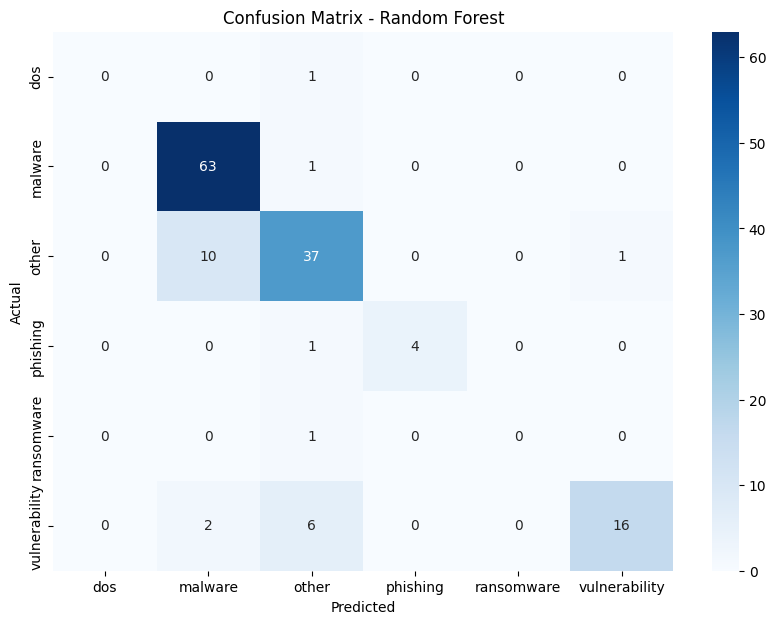

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Support Vector Machine (SVM)

SVM Classifier Results:
               precision    recall  f1-score   support

          dos       0.00      0.00      0.00         1
      malware       0.74      0.89      0.81        64
        other       0.84      0.67      0.74        48
     phishing       0.83      1.00      0.91         5
   ransomware       0.00      0.00      0.00         1
vulnerability       0.77      0.71      0.74        24

     accuracy                           0.78       143
    macro avg       0.53      0.54      0.53       143
 weighted avg       0.77      0.78      0.77       143

Accuracy: 0.7762237762237763


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


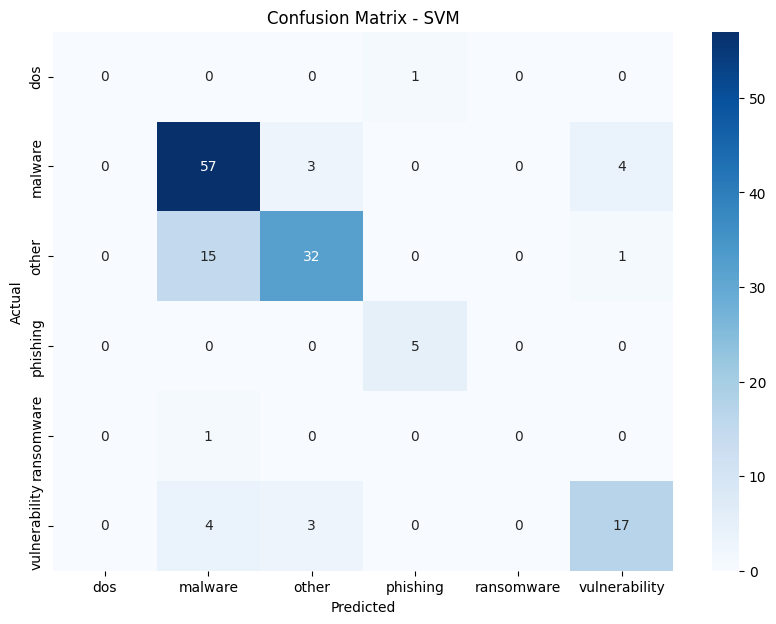

In [ ]:
# SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("SVM Classifier Results:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

Step 4: Model Evaluation and Selection

Random Forest Accuracy: 0.8391608391608392
SVM Accuracy: 0.7762237762237763
Top 10 Important Features:
               importance
malware          0.106438
phishing         0.024694
vulnerability    0.023262
remove           0.017678
antivirus        0.015198
software         0.013830
activity         0.013344
latest           0.012920
id_1             0.012509
patch            0.011110


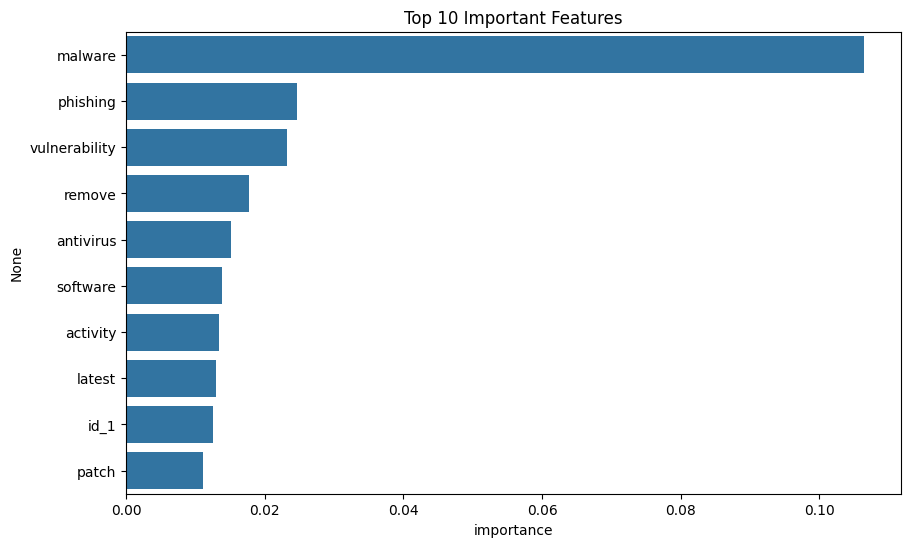

In [ ]:
# Compare model performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Feature importance from Random Forest
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("Top 10 Important Features:")
print(feature_importances.head(10))

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.head(10)['importance'],
            y=feature_importances.head(10).index)
plt.title('Top 10 Important Features')
plt.show()

Step 6: Model Optimization

/tmp/ipython-input-28-824973865.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


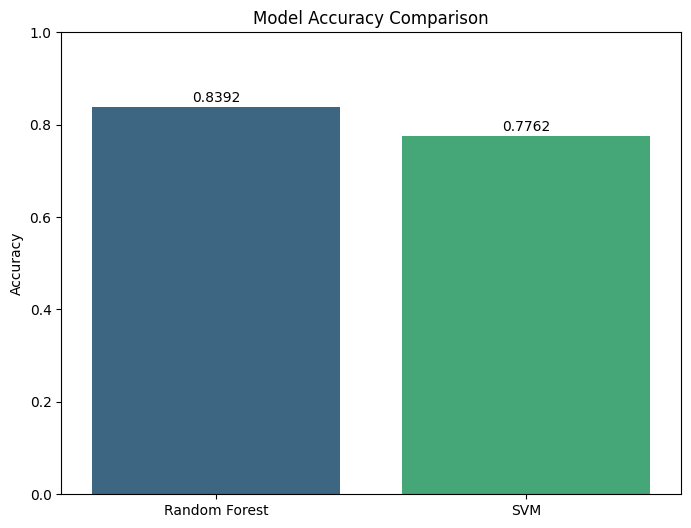

In [ ]:
#here compare the both model accuracy and plot the graph
# Collect accuracies
rf_accuracy = accuracy_score(y_test, y_pred_rf)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

models = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

# Plot the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for accuracy
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.show()

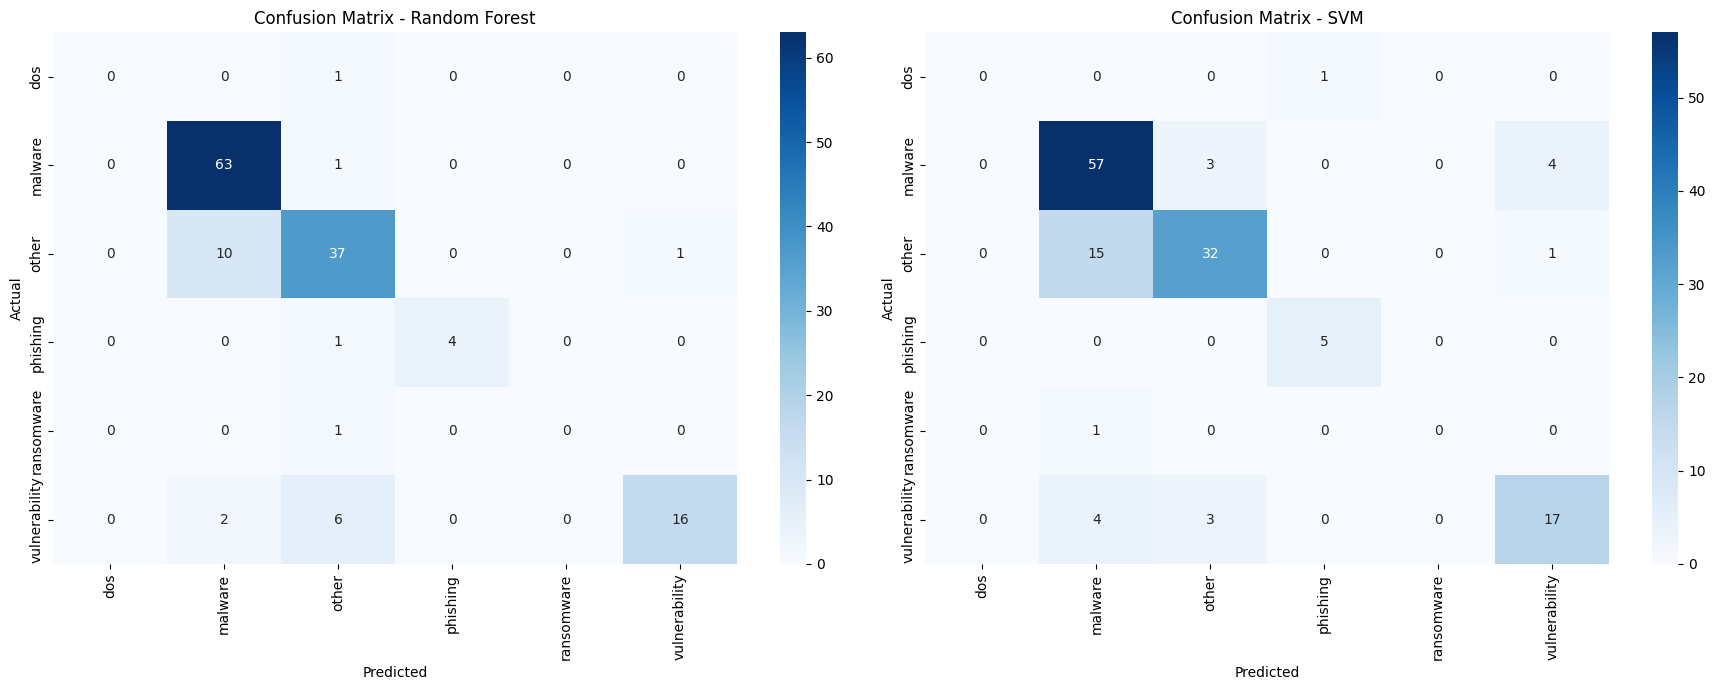

In [ ]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plotting both confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plotting Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Random Forest')

# Plotting SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - SVM')

plt.tight_layout()
plt.show()

Step 7: Model Deployment and Prediction

In [ ]:
import joblib
import numpy as np

def preprocess_text(text):
    """Text cleaning function (make sure this is defined)"""
    # Add your text preprocessing steps here
    return text.lower()  # Simple example - replace with your actual preprocessing

def predict_threat(new_text, new_diagnosis, new_solutions):

    #Predicts the cyber threat type without probability scores
    try:
        # Load saved models
        model = joblib.load('cyber_threat_rf_model.pkl')
        tfidf = joblib.load('tfidf_vectorizer.pkl')
        scaler = joblib.load('feature_scaler.pkl')
        le = joblib.load('label_encoder.pkl')

        # Preprocess the input
        processed_text = preprocess_text(new_text)
        processed_diag = preprocess_text(new_diagnosis)
        processed_sol = preprocess_text(new_solutions)
        combined = processed_text + ' ' + processed_diag + ' ' + processed_sol

        # Vectorize the text
        text_features = tfidf.transform([combined]).toarray()

        # Create feature vector
        num_total_features = 1004  # Update this based on your actual feature count
        features = np.zeros((1, num_total_features))
        features[0, -text_features.shape[1]:] = text_features

        # Scale features
        features_scaled = scaler.transform(features)

        # Predict and return only the threat type
        prediction = model.predict(features_scaled)
        return le.inverse_transform(prediction)[0]

    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return "unknown"

# Example usage
sample_text = "A new Android malware named AnubisSpy has been detected spreading via fake app stores."
sample_diag = "The malware collects sensitive user data and communicates with C2 servers at 107.180.46.243."
sample_sol = "1. Install reputable antivirus software 2. Educate users about safe app downloads 3. Monitor network traffic for C2 communications"

threat_type = predict_threat(sample_text, sample_diag, sample_sol)
print("Predicted Threat Type:", threat_type)

Predicted Threat Type: malware


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Cyber Threat Intelligence Analysis System
Table of Contents:
    Data Pipeline Architecture

    Machine Learning Models

    Implementation Process

    Evaluation Methodology

    Deployment Strategy
1. System Overview
Objective
Develop a multi-class classification system that:

Identifies cyber threat types (malware, phishing, DoS, etc.)

Detects anomalous threat patterns

Provides probabilistic confidence scores

2. Data Pipeline Architecture
Data Preparation Process
Step 1: Data Ingestion:

    CSV file with 50+ features

    Primary text fields: text, diagnosis, solutions

    Categorical labels extracted from diagnosis

Step 2: Cleaning Pipeline

Null Handling:

    Text fields → Empty string

    Numerical → Median imputation

    Categorical → Mode imputation
Step 3: Feature Construction

    TF-IDF Vectorization (1000 dimensions)

    Combined text feature: text + diagnosis + solutions

    Threat type labels extracted via regex patterns

3. Machine Learning Models
Supervised Models
A. Random Forest Classifier

    Architecture: 100 decision trees

Advantages:

    Handles high-dimensional text data

    Robust to overfitting

    Provides feature importance

B. Support Vector Machine (SVM)

    Kernel: Linear (for text classification)

    Strength: Effective in high-dimensional spaces  

4. Implementation Process
Training Phase:
    Feature extraction
    model training
    anomlay detection

Prediction Workflow
1.Input Processing:

    Text cleaning and normalization

    TF-IDF transformation
2.Feature Assembly
3.CLassification :

    Predicts threat type
    Returns probability distribution

5. Evaluation Methodology
Metrics
    Metric	Formula	Target
    Accuracy	(TP+TN)/(TP+TN+FP+FN)	>85%
    Precision	TP/(TP+FP)	>80%
    Recall	TP/(TP+FN)	>75%
    F1-Score	2(PrecisionRecall)/(P+R)	>80%
